# 1. Introduction

The primary purpose of our analysis is to put into relationship two different types of data at the level of municipalities/communities in the Canton of Thurgau: financial and Energy consumption data. We want to test if there is a relationship between the taxable income of individual persons and Energy consumption. It is clear that more taxable income leads to more Energy consumption at the municipality level, because both correlate with the number of inhabitants. However, does it still hold when scaled by the number of inhabitants? <br> The main question is if Energy consumption decreases with increasing income, because people then invest in energy saving devices, for example heating systems, or if the consumption increases because more goods are consumed. Alternatively (H0 hypothesis) there may be no relationship between both variables.<br>
The analysis potentially can help the authorities of Canton Thurgau to focus and define the correct Energy saving policies. This framework is of course simplified, because there may be more relevant but unknown factors that can potentially influence Energy consumption which is not available statistically at the level of municipalities.

#2. Description of the datasets

1. Average taxable income of individual persons.

   Bundesamt für Statistik: https://www.bfs.admin.ch/asset/de/21324555


2. Statistical data of the Canton Thurgau

   The dataset includes final Energy consumption in the building sector for space heating and hot water by energy source and by municipality as of 2015. Consumption from Industry and Farming are excluded.

   https://opendata.swiss/de/dataset/endenergieverbrauch-im-gebaudebereich-nach-energietragern-und-gemeinden



3. Mapping information for displaying the Canton of Thurgau on a municipality level.

   www.gadm.org



### Install and import modules

In [ ]:
#@title
%%capture
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install geopandas
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

In [1]:
#@title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from functools import reduce
import plotly.express as px
import seaborn as sns
import geopandas as gpd

Upload the datasets to Google Colab


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving div-energie-5.csv to div-energie-5.csv


### Read the datasets

#### Average taxable income

Definition of column names and loading of the excel files for each available  year. Notice that there is a different number of rows, that is municipalities, pro year.

In [2]:
# Columns names in the Excel file
column_names = ["Regions-ID", "Regionsname", "Steuerbares Einkommen, in Mio CHF", "Steuerbares Einkommen pro Steuerpflichtigem/-r, in Franken"]

# Read Excel in to dataframe
tax_2014_df = pd.read_excel("Steuerpflichtige_2014.xlsx", names=column_names,  skiprows=5, nrows=2352)  
tax_2015_df = pd.read_excel("Steuerpflichtige_2015.xlsx", names=column_names,  skiprows=5, nrows=2324)
tax_2016_df = pd.read_excel("Steuerpflichtige_2016.xlsx", names=column_names,  skiprows=5, nrows=2294)
tax_2017_df = pd.read_excel("Steuerpflichtige_2017.xlsx", names=column_names,  skiprows=5, nrows=2255)
tax_2018_df = pd.read_excel("Steuerpflichtige_2018.xlsx", names=column_names,  skiprows=5, nrows=2222)


Remark: The different tax files do not have the same number of municipalities. This is mainly due to the merge of municipalities.
- Are there mergers in Thurgau? <br> In the analysed period there was no merger of municipalities in the canton. <br> There was a bigger merger wave between 1995 and 2000 from 217 to 80 municipalities, but since then merger was no topic any more. In the future there will probably be mergers again as the Union of the Municipalities mandated in 2020 guidelines for municipality mergers.

##### Combine the different tax years in one dataframe

In [3]:
data_frames = [tax_2014_df, tax_2015_df, tax_2016_df, tax_2017_df, tax_2018_df]

from functools import reduce
tax_merged = reduce(lambda  left,right: pd.merge(left,right,on=["Regions-ID", "Regionsname"], how='outer'), data_frames)

# write clean, easy to understand column names
tax_merged.columns = ['Regions-ID', 'Regionsname',
                      'Einkommen Total 2014', 'Einkommen pro Person 2014',
                      'Einkommen Total 2015', 'Einkommen pro Person 2015', 
                      'Einkommen Total 2016', 'Einkommen pro Person 2016', 
                      'Einkommen Total 2017', 'Einkommen pro Person 2017',
                      'Einkommen Total 2018', 'Einkommen pro Person 2018']

# sort dataframe by Regions-ID
tax_df = tax_merged.sort_values("Regions-ID")


tax_df.set_index('Regions-ID',inplace=True)
tax_df.head(3)

/tmp/ipykernel_14158/23743759.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Steuerbares Einkommen, in Mio CHF_x', 'Steuerbares Einkommen pro Steuerpflichtigem/-r, in Franken_x'} in the result is deprecated and will raise a MergeError in a future version.
  tax_merged = reduce(lambda  left,right: pd.merge(left,right,on=["Regions-ID", "Regionsname"], how='outer'), data_frames)


,Regionsname,Einkommen Total 2014,Einkommen pro Person 2014,Einkommen Total 2015,Einkommen pro Person 2015,Einkommen Total 2016,Einkommen pro Person 2016,Einkommen Total 2017,Einkommen pro Person 2017,Einkommen Total 2018,Einkommen pro Person 2018
Regions-ID,,,,,,,,,,,
1,Aeugst am Albis,95.6855,105846.792035,94.4072,105013.570634,101.3324,111354.285714,97.9089,108787.666667,101.1675,X
2,Affoltern am Albis,359.6882,71593.988854,372.8508,71059.805603,381.2711,73279.088987,390.8602,72583.138347,394.6064,72524.609447
3,Bonstetten,204.7047,90178.281938,210.9365,88927.698145,214.2104,90460.472973,223.5911,91001.668702,226.1247,90017.794586


#### Energy consumption

In [5]:
df_energie=pd.read_csv(r"div-energie-5.csv")

# Define same name for the Index (Region ID) as in the tax file and rename the municipalities index to the same name as in the tax file
df_energie = df_energie.rename(columns={'BFS_NR_GEMEINDE': 'Regions-ID'})
df_energie = df_energie.rename(columns={'total': 'Endenergieverbrauch Total'})

df_energie.head(3)

,JAHR,Regions-ID,GEMEINDE_NAME,EINWOHNER,energiebezugsflaeche,erdoelbrennstoffe,erdgas,elektrizitaet,holzenergie,fernwaerme,umweltwaerme,solarwaerme,andere,Endenergieverbrauch Total
0,2020,4461,Amriswil,14157,1163632,53.830,33.391,9.435,7.710,4.121,10.892,0.446,0.138,119.962
1,2020,4401,Arbon,14872,1206961,63.956,32.284,10.533,2.423,8.313,8.959,0.343,0.651,127.462
2,2020,4536,Basadingen-Schlattingen,1814,168913,9.660,0.269,2.926,3.094,0.096,2.821,0.161,NaN,19.027




---



Create a dataframe per year

In [6]:
# create dataframe per year
df_ener_2018 = df_energie[df_energie['JAHR']==2018]
df_ener_2018.set_index('Regions-ID',inplace=True)
df_ener_2017 = df_energie[df_energie['JAHR']==2017]
df_ener_2017.set_index('Regions-ID',inplace=True)
df_ener_2016 = df_energie[df_energie['JAHR']==2016]
df_ener_2016.set_index('Regions-ID',inplace=True)
df_ener_2015 = df_energie[df_energie['JAHR']==2015]
df_ener_2015.set_index('Regions-ID',inplace=True)

# Sort Energy dataframe by the Index
df_ener_2018 = df_ener_2018.sort_values("Regions-ID")
df_ener_2017 = df_ener_2017.sort_values("Regions-ID")
df_ener_2016 = df_ener_2016.sort_values("Regions-ID")
df_ener_2015 = df_ener_2015.sort_values("Regions-ID")

df_ener_2017.head(3)

,JAHR,GEMEINDE_NAME,EINWOHNER,energiebezugsflaeche,erdoelbrennstoffe,erdgas,elektrizitaet,holzenergie,fernwaerme,umweltwaerme,solarwaerme,andere,Endenergieverbrauch Total
Regions-ID,,,,,,,,,,,,,
4401,2017,Arbon,14430,1167574,74.231,31.137,9.930,2.617,7.021,7.370,0.311,1.155,133.773
4406,2017,Dozwil,704,48755,2.261,0.975,0.758,1.130,0.066,0.589,0.030,NaN,5.810
4411,2017,Egnach,4692,412545,21.032,11.026,5.054,8.513,0.414,3.876,0.379,0.379,50.674


The tax data is available for all municipalities in Switzerland, but we focus on the ones in Canton Thurgau.

In [7]:
# Extract the list of relevant Regions an apply it as a Filter to the Tax File
Regions_ct_TG = df_ener_2017.index.values
tax_df = tax_df.loc[Regions_ct_TG]

tax_df # there are 80 rows left as expected

,Regionsname,Einkommen Total 2014,Einkommen pro Person 2014,Einkommen Total 2015,Einkommen pro Person 2015,Einkommen Total 2016,Einkommen pro Person 2016,Einkommen Total 2017,Einkommen pro Person 2017,Einkommen Total 2018,Einkommen pro Person 2018
Regions-ID,,,,,,,,,,,
4401,Arbon,373.0601,60190.400129,380.3400,60170.859041,393.6852,61388.616872,398.3984,62181.738723,402.3692,62046.13724
4406,Dozwil,15.8665,63466.000000,16.0707,63772.619048,17.7725,65340.073529,18.8648,70391.044776,19.3355,71612.962963
4411,Egnach,130.6499,68188.883090,136.7645,70752.457320,145.4011,71838.488142,147.3966,71482.347236,151.0958,72537.590014
4416,Hefenhofen,30.7747,61549.400000,31.2214,63587.372709,32.1196,61768.461538,31.7184,63819.718310,32.5693,X
4421,Horn,97.3816,74054.448669,97.9485,72662.091988,103.0108,74971.470160,112.5599,76156.901218,118.6447,79149.232822
...,...,...,...,...,...,...,...,...,...,...,...
4911,Bürglen (TG),91.0066,58638.273196,92.8183,59233.120613,96.3266,60053.990025,97.6339,61250.878294,99.2546,61042.189422
4921,Bussnang,57.6555,64854.330709,60.7429,65739.069264,60.6957,64092.608237,61.4342,63728.423237,63.2230,64447.502548
4941,Märstetten,83.8443,69465.037283,83.8776,69377.667494,89.2916,70754.041204,90.4963,71200.865460,98.7596,74761.241484


Combine the tax and the energy dataframe and check if we have the correct number of municiipalities.  <br> This is not the case. For 2018 the income is missing for some municipalities. We will, therefore, mainly focus on the year 2017 for our analysis.

In [8]:
tax_energy_2018 = pd.concat([tax_df, df_ener_2018], axis=1)
# tax_energy_2018 = tax_energy_2018[tax_energy_2018['Endenergieverbrauch Total'].isnull()==False] 
tax_energy_2018 = tax_energy_2018[tax_energy_2018['Einkommen pro Person 2018']  != 'X' ]

tax_energy_2017 = pd.concat([tax_df, df_ener_2017], axis=1)
tax_energy_2017 = tax_energy_2017[tax_energy_2017['Einkommen pro Person 2017']  != 'X' ]

tax_energy_2016 = pd.concat([tax_df, df_ener_2016], axis=1)
tax_energy_2016 = tax_energy_2016[tax_energy_2016['Einkommen pro Person 2016']  != 'X' ]

tax_energy_2015 = pd.concat([tax_df, df_ener_2015], axis=1)
tax_energy_2015 = tax_energy_2015[tax_energy_2015['Einkommen pro Person 2015']  != 'X' ]

# check if we have all the municipalities of the Canton Thurgau
for key, value in {2018:tax_energy_2018, 2017:tax_energy_2017, 2016:tax_energy_2016, 2015:tax_energy_2015}.items():
  if len(value) == 80:
    print(f"For the year {key} all municipalities are in our dataframe")
  else:
    print(f"For the year {key} we don't have the correct number of municipalities\nWe have {len(value)} instead of 80")

For the year 2018 we don't have the correct number of municipalities
We have 57 instead of 80
For the year 2017 all municipalities are in our dataframe
For the year 2016 all municipalities are in our dataframe
For the year 2015 all municipalities are in our dataframe


#### Histograms

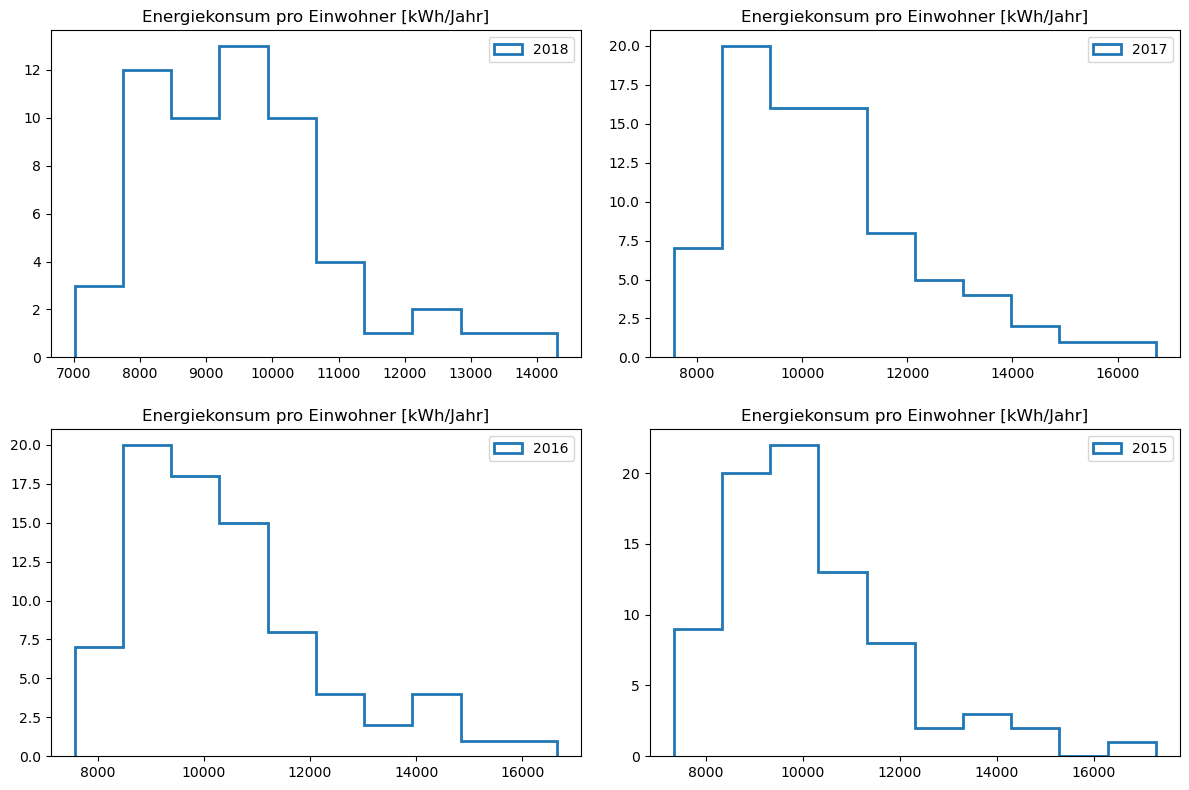

In [9]:
# plot
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title("Energiekonsum pro Einwohner [kWh/Jahr]")
plt.hist(tax_energy_2018["Endenergieverbrauch Total"]/tax_energy_2018["EINWOHNER"]*1000*1000, bins=10, histtype="step", linewidth=2, label="2018")
plt.legend()

plt.subplot(2, 2, 2)
plt.title("Energiekonsum pro Einwohner [kWh/Jahr]")
plt.hist(tax_energy_2017["Endenergieverbrauch Total"]/tax_energy_2017["EINWOHNER"]*1000*1000, bins=10, histtype="step", linewidth=2, label="2017")
plt.legend()

plt.subplot(2, 2, 3)
plt.title("Energiekonsum pro Einwohner [kWh/Jahr]")
plt.hist(tax_energy_2016["Endenergieverbrauch Total"]/tax_energy_2016["EINWOHNER"]*1000*1000, bins=10, histtype="step", linewidth=2, label="2016")
plt.legend()

plt.subplot(2, 2, 4)
plt.title("Energiekonsum pro Einwohner [kWh/Jahr]")
plt.hist(tax_energy_2015["Endenergieverbrauch Total"]/tax_energy_2015["EINWOHNER"]*1000*1000, bins=10, histtype="step", linewidth=2, label="2015")
plt.legend()

plt.tight_layout(h_pad=2, w_pad=2)
plt.legend()
plt.show()

# Additionnaly we could check here (in the annex, if the distribution is the same over the years)

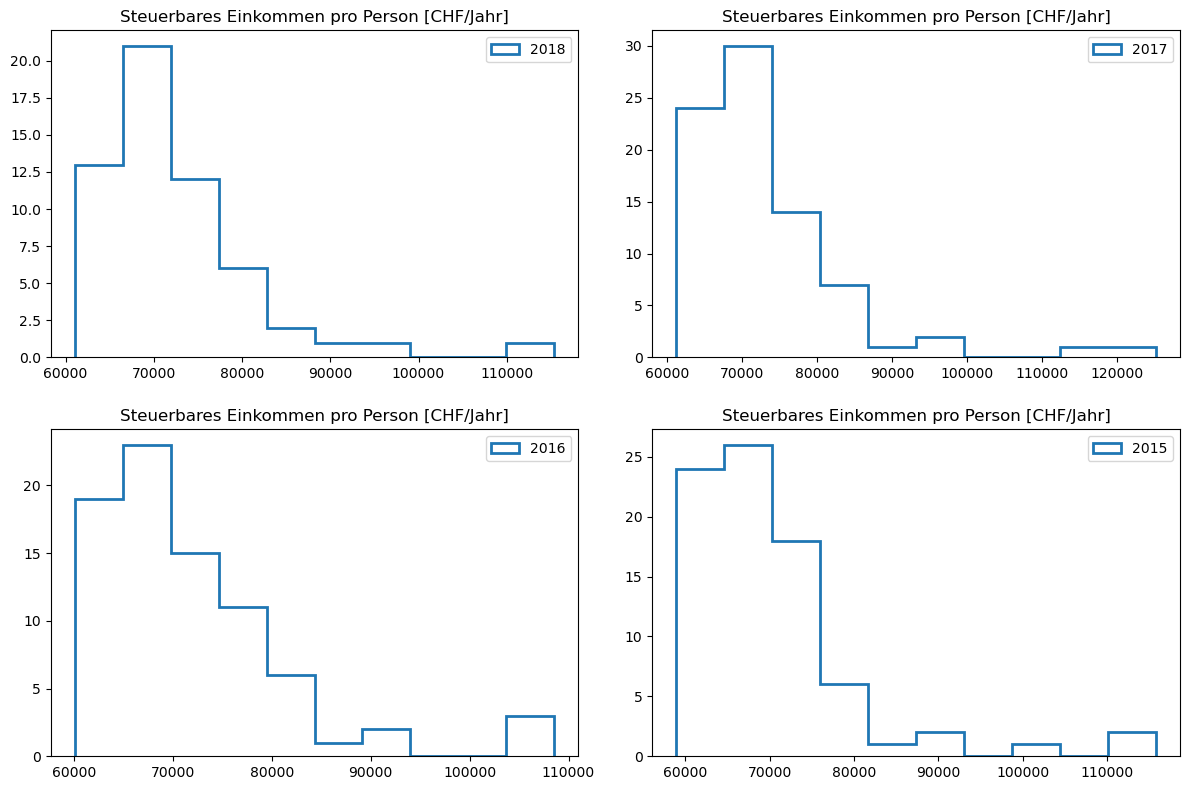

In [10]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title("Steuerbares Einkommen pro Person [CHF/Jahr]")
plt.hist(tax_energy_2018["Einkommen pro Person 2018"], bins=10, histtype="step", linewidth=2, label="2018")
plt.legend()

plt.subplot(2, 2, 2)
plt.title("Steuerbares Einkommen pro Person [CHF/Jahr]")
plt.hist(tax_energy_2017["Einkommen pro Person 2017"], bins=10, histtype="step", linewidth=2, label="2017")
plt.legend()

plt.subplot(2, 2, 3)
plt.title("Steuerbares Einkommen pro Person [CHF/Jahr]")
plt.hist(tax_energy_2016["Einkommen pro Person 2016"], bins=10, histtype="step", linewidth=2, label="2016")
plt.legend()

plt.subplot(2, 2, 4)
plt.title("Steuerbares Einkommen pro Person [CHF/Jahr]")
plt.hist(tax_energy_2015["Einkommen pro Person 2015"], bins=10, histtype="step", linewidth=2, label="2015")
plt.legend()

plt.tight_layout(h_pad=2, w_pad=2)
plt.legend()
plt.show()

The histograms above show a positive skew for the different years for both taxable income and energy consumption.

---



#### Scatter plots comparing the Energy consumption over time and over municipalities. We then do the same for the income. For our main year 2017 we represent both as a map as it is easier to read. We see that there are not many big jumps over time, which justifies focussing on one year. For the years 2014, 2015 and 2018, some results are displayed in chapters 6.3 and 6.4 in Appendix.

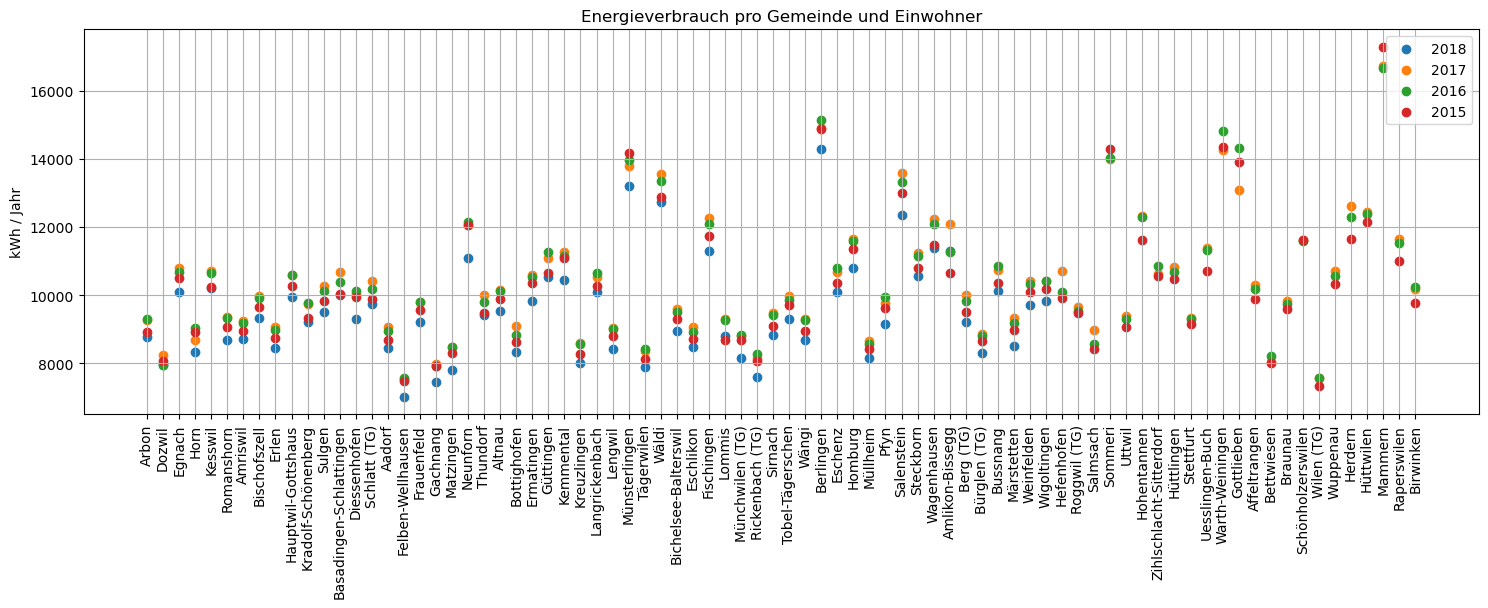

In [11]:
plt.rcParams['figure.figsize'] = (18, 5)

fig, ax = plt.subplots()

ax.scatter(tax_energy_2018["Regionsname"], tax_energy_2018["Endenergieverbrauch Total"]/tax_energy_2018["EINWOHNER"]*1000*1000, label='2018')
ax.scatter(tax_energy_2017["Regionsname"], tax_energy_2017["Endenergieverbrauch Total"]/tax_energy_2017["EINWOHNER"]*1000*1000, label='2017')
ax.scatter(tax_energy_2016["Regionsname"], tax_energy_2016["Endenergieverbrauch Total"]/tax_energy_2016["EINWOHNER"]*1000*1000, label='2016')
ax.scatter(tax_energy_2015["Regionsname"], tax_energy_2015["Endenergieverbrauch Total"]/tax_energy_2015["EINWOHNER"]*1000*1000, label='2015')

ax.tick_params(axis='x', labelrotation = 90)

ax.set_title("Energieverbrauch pro Gemeinde und Einwohner")
plt.ylabel("kWh / Jahr")
plt.legend()
plt.grid(visible=True)

# fig.savefig('test.png', dpi=300)
plt.legend()
plt.show()

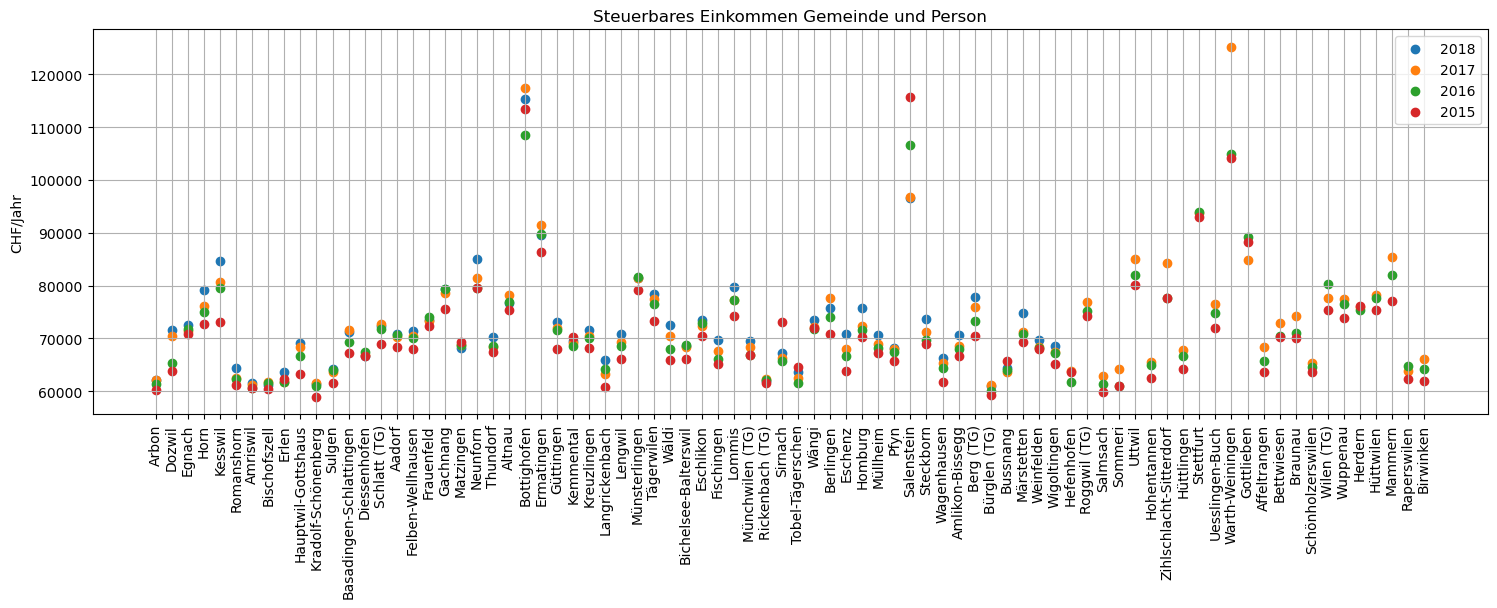

In [12]:
plt.rcParams['figure.figsize'] = (18, 5)

fig, ax = plt.subplots()

ax.scatter(tax_energy_2018["Regionsname"], tax_energy_2018["Einkommen pro Person 2018"], label='2018')
ax.scatter(tax_energy_2017["Regionsname"], tax_energy_2017["Einkommen pro Person 2017"], label='2017')
ax.scatter(tax_energy_2016["Regionsname"], tax_energy_2016["Einkommen pro Person 2016"], label='2016')
ax.scatter(tax_energy_2015["Regionsname"], tax_energy_2015["Einkommen pro Person 2015"], label='2015')

ax.tick_params(axis='x', labelrotation = 90)

ax.set_title("Steuerbares Einkommen Gemeinde und Person")
plt.ylabel("CHF/Jahr")
plt.legend()
plt.grid(visible=True)


# fig.savefig('test.png', dpi=300)
plt.legend()
plt.show()

Map of the Tax distribution

In [13]:
#@title
# read the shape file
map_df = gpd.read_file("gadm41_CHE_3.shp")

# replace Community name to match the shape file
rep = tax_energy_2017.replace(["Roggwil (TG)", "Schlatt (TG)", "Wilen (TG)", "Berg (TG)", "Bürglen (TG)", "Rickenbach (TG)"],
                              ["Roggwil", "Schlatt bei Diessenhofen", "Wilen", "Berg", "Bürglen", "Rickenbach"]).copy()

# merge the two dataframes
merged_map_df = map_df.merge(rep, how="left", left_on="NAME_3", right_on="Regionsname")

# filter Canton Thurgau
df = merged_map_df[map_df["NAME_1"]=="Thurgau"]


libarrow.so.800: cannot open shared object file: No such file or directory
libarrow.so.800: cannot open shared object file: No such file or directory
libhdf5.so.200: cannot open shared object file: No such file or directory
libhdf5.so.200: cannot open shared object file: No such file or directory
libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
libmariadb.so.3: cannot open shared object file: No such file or directory
libmariadb.so.3: cannot open shared object file: No such file or directory
libnetcdf.so.19: cannot open shared object file: No such file or directory
libnetcdf.so.19: cannot open shared object file: No such file or directory
libarrow.so.800: cannot open shared object file: No such file or directory
libarrow.so.800: cannot open shared object file: No such file or directory
libarrow.so.800: cannot open shared object file: No such file or directory
libarrow.so.800: cann

/usr/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


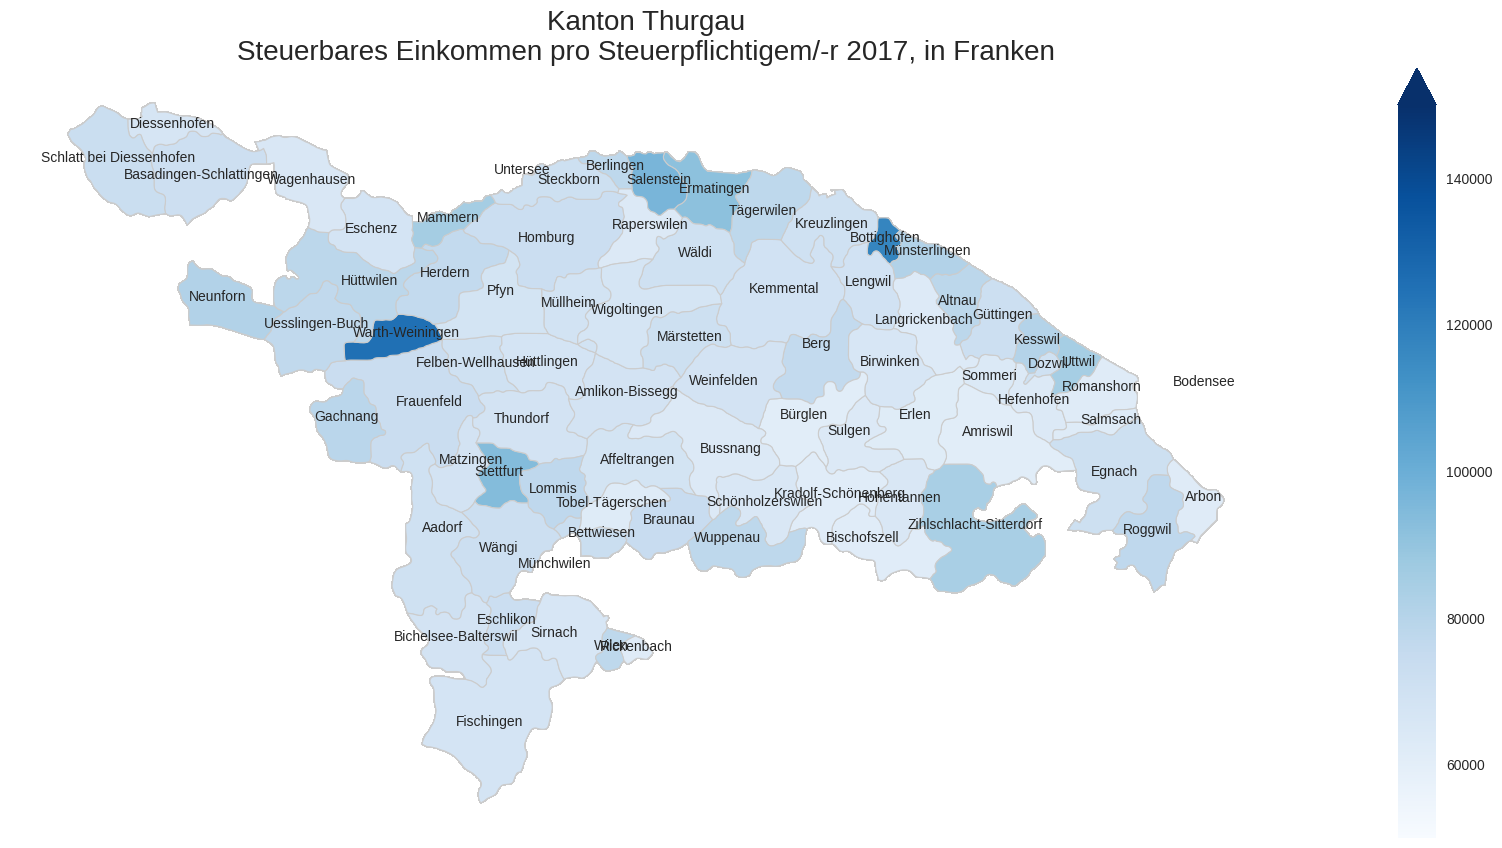

In [48]:
#@title

# vmax = df["Steuerbares Einkommen pro Steuerpflichtigem/-r, in Franken"].max()
# vmin = df["Steuerbares Einkommen pro Steuerpflichtigem/-r, in Franken"].min()
title = "Kanton Thurgau\nSteuerbares Einkommen pro Steuerpflichtigem/-r 2017, in Franken"

vmin = 50000
vmax = 150000

sm1 = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig, ax = plt.subplots(1, figsize=(30, 10))
ax.axis("off") 
ax.set_title(title, fontdict={'fontsize': '20', 'fontweight' : '3'})
sm1.set_array([])
fig.colorbar(sm1, ax=ax, extend="max")



# get the coordinats
df['coords'] = df['geometry'].apply(lambda x: x.representative_point().coords[:]) 
df['coords'] = [coords[0] for coords in df['coords']]

# plot
for idx, row in df.iterrows():
    plt.annotate(row['NAME_3'], xy=row['coords'],horizontalalignment='center')  
    df.plot(column=df["Einkommen pro Person 2017"], cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8',vmin=vmin, vmax=vmax) 

# fig.savefig('test.png', dpi=300)   
plt.show()


#### Scatter plot of our two main dimensions: the tax income pro tax payer and the energy consumption pro person. Visually we can no more than guess some relationship so we will need to test the relationship formally. As next, in the next chapter, we will  formally formulate the hypothesis we want to test.

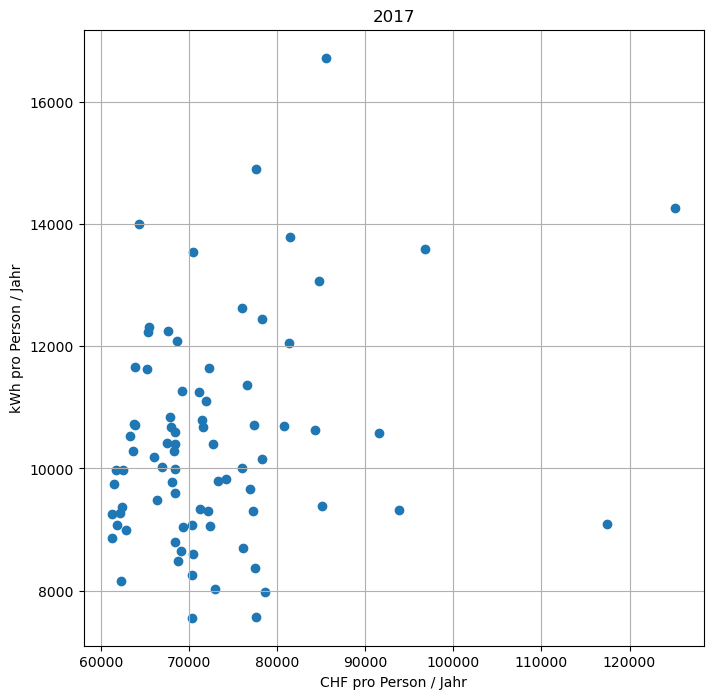

In [15]:
plt.rcParams['figure.figsize'] = (8, 8)

fig, ax = plt.subplots()

ax.scatter(tax_energy_2017["Einkommen pro Person 2017"], tax_energy_2017["Endenergieverbrauch Total"]/tax_energy_2017["EINWOHNER"]*1000*1000)

ax.set_title("2017")
plt.xlabel("CHF pro Person / Jahr")
plt.ylabel("kWh pro Person / Jahr")
# plt.legend()
plt.grid(visible=True)

# fig.savefig('test.png', dpi=300)

plt.show()

#3. Hypothesis


H1: The Energy consumption pro persons depends on the financial situation  (in our case, the tax Income pro person)<br>
H0: The energy consumption is independent from the financial situation


The desired degree of certainty = 95%

We intend to test this using a linear regression between the two variables. If the sign of the coefficient is either positive or negative and it is significant, there is a dependency. Else we cannot prove that the variables are dependent.
The conditions for the linear regression have to be fulfilled.


#4. Test the hypothesis

### Normality of the variables

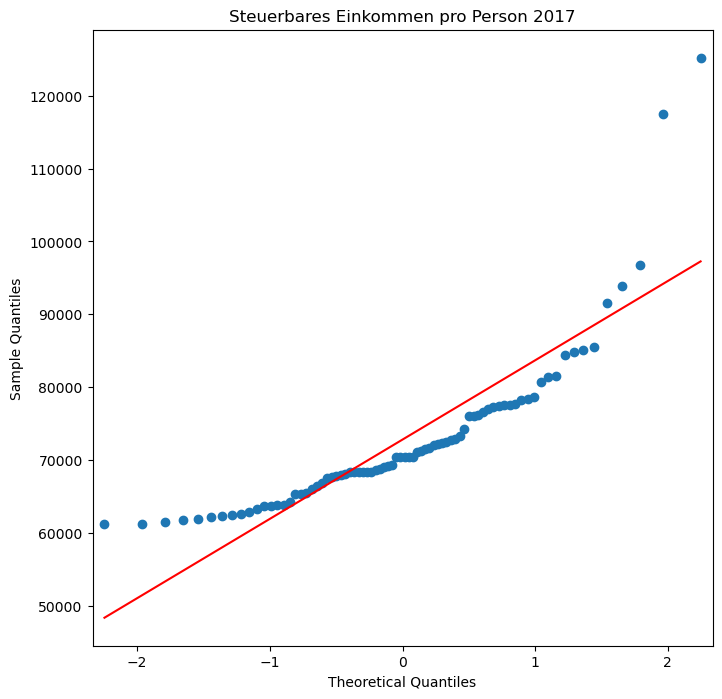



D'Agostino-Pearson normality test:
p = 0.000000
The data is not normaly distributed


In [16]:
# Make our plots bigger.
plt.rcParams['figure.figsize'] = (8, 8)

a = tax_energy_2017["Einkommen pro Person 2017"]

fig = sm.qqplot(a, line="s")


plt.title("Steuerbares Einkommen pro Person 2017")
plt.show()

# D'Agostino-Pearson normality test
k2, p = stats.normaltest(a)
alpha = 1-0.05
print(f"\n\nD'Agostino-Pearson normality test:\np = {p:.6f}")
if p < alpha:
  print("The data is not normaly distributed")
else:
  print("The data is normaly distributed")


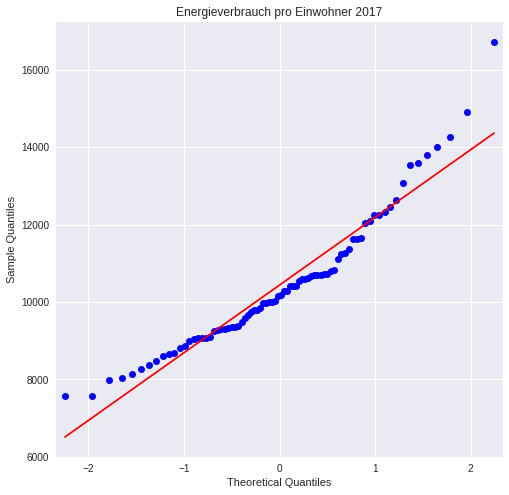



D'Agostino-Pearson normality test:
p = 0.000277
The data is not normaly distributed


In [ ]:
a = tax_energy_2017["Endenergieverbrauch Total"]/tax_energy_2017["EINWOHNER"]*1000*1000  # to go from GWh to kWh

fig = sm.qqplot(a, line="s")

# Make our plots bigger.
plt.rcParams['figure.figsize'] = (8, 8)

plt.title("Energieverbrauch pro Einwohner 2017")
plt.show()

# D'Agostino-Pearson normality test
k2, p = stats.normaltest(a)
alpha = 1-0.05
print(f"\n\nD'Agostino-Pearson normality test:\np = {p:.6f}")
if p < alpha:
  print("The data is not normaly distributed")
else:
  print("The data is normaly distributed")

In [17]:

energy = tax_energy_2017["Endenergieverbrauch Total"]/tax_energy_2017["EINWOHNER"]*1000*1000
tax = tax_energy_2017["Einkommen pro Person 2017"]

stat, pvalue = stats.wilcoxon(tax, energy, alternative='two-sided')

alpha = 0.95

print("Wilcoxon signed-rank test for not normally distributed paired data")
if p < 1 - alpha:
  print(f"p-value: {pvalue:.6f} < {1-alpha:.6f}\nWe can reject the H0")
else:
  print(f"p-value: {pvalue:.6f} > {1-alpha:.6f}\nWe cannot reject the H0")

Wilcoxon signed-rank test for not normally distributed paired data
p-value: 0.000000 < 0.050000
We can reject the H0


In annex (chapter 6.2) we test additionally if the two variables rather follow a lognormal distribution. In both cases the hypothesis is rejected.


### Linear Regression between taxable income and energy consumption

In [18]:
# linear regression

X = tax_energy_2017["Einkommen pro Person 2017"]
y = tax_energy_2017["Endenergieverbrauch Total"]/tax_energy_2017["EINWOHNER"]*1000*1000

X2 = sm.add_constant(X) # make sure that the model has an intercept
# est = sm.OLS(formula="volume ~ diam * height**2", endog=y, exog=x)
est = sm.OLS(y, X2) # run OLS
model = est.fit()

intercept, slope = model.params # print model parameters
std_intersept, std_slope = model.bse
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     6.092
Date:                Wed, 21 Sep 2022   Prob (F-statistic):             0.0158
Time:                        17:48:23   Log-Likelihood:                -707.87
No. Observations:                  80   AIC:                             1420.
Df Residuals:                      78   BIC:                             1425.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


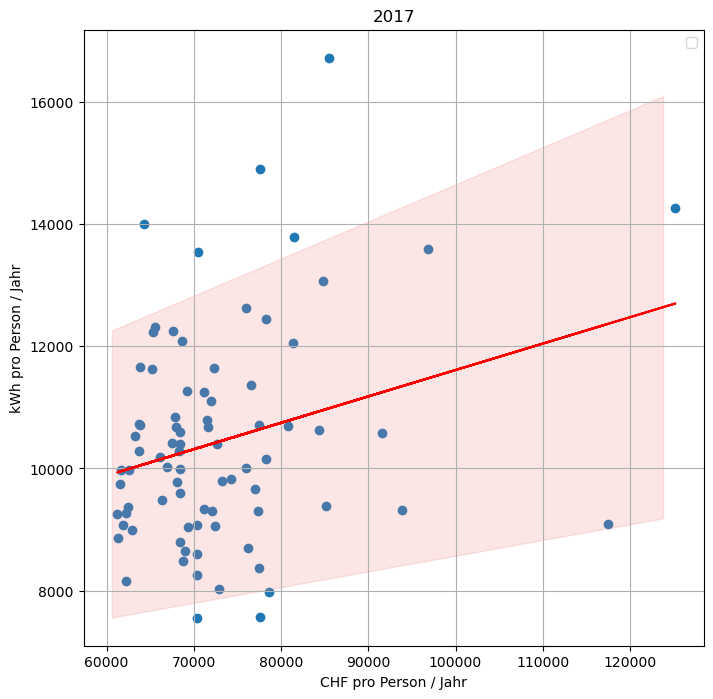

In [19]:
fig, ax = plt.subplots()

ax.scatter(tax_energy_2017["Einkommen pro Person 2017"], tax_energy_2017["Endenergieverbrauch Total"]/tax_energy_2017["EINWOHNER"]*1000*1000)
plt.plot(X, intercept + slope*X, 'r')
# plt.plot(X, (intercept + std_intersept) + (slope + std_slope) * X, 'g', label="SD")
# plt.plot(X, (intercept - std_intersept) + (slope - std_slope) * X, 'g')


X2 = np.linspace(60600, 123800, 10)
ax.fill_between(X2, (intercept + std_intersept) + (slope + std_slope) * X2, (intercept - std_intersept) + (slope - std_slope) * X2, alpha=0.2, color="lightcoral")

ax.set_title("2017")
plt.xlabel("CHF pro Person / Jahr")
plt.ylabel("kWh pro Person / Jahr")
plt.legend()
plt.grid(visible=True)

# Make our plots bigger.
plt.rcParams['figure.figsize'] = (8, 8)

# fig.savefig('test.png', dpi=300)

plt.show()

Let's have a look at the diagnostic plots.

In [20]:
#@title
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn') # pretty matplotlib plots

def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
  """
  Function to reproduce the 4 base plots of an OLS model in R.

  ---
  Inputs:

  X: A numpy array or pandas dataframe of the features to use in building the linear regression model

  y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

  model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
  """

  if not model_fit:
      model_fit = sm.OLS(y, sm.add_constant(X)).fit()

  # create dataframe from X, y for easier plot handling
  dataframe = pd.concat([X, y], axis=1)

  # model values
  model_fitted_y = model_fit.fittedvalues
  # model residuals
  model_residuals = model_fit.resid
  # normalized residuals
  model_norm_residuals = model_fit.get_influence().resid_studentized_internal
  # absolute squared normalized residuals
  model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
  # absolute residuals
  model_abs_resid = np.abs(model_residuals)
  # leverage, from statsmodels internals
  model_leverage = model_fit.get_influence().hat_matrix_diag
  # cook's distance, from statsmodels internals
  model_cooks = model_fit.get_influence().cooks_distance[0]


  plot_lm_1 = plt.figure()
  plot_lm_1.axes[0] = sns.residplot(model_fitted_y, y, data=dataframe,
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

  plot_lm_1.axes[0].set_title('Residuals vs Fitted')
  plot_lm_1.axes[0].set_xlabel('Fitted values')
  plot_lm_1.axes[0].set_ylabel('Residuals');

  # annotations
  abs_resid = model_abs_resid.sort_values(ascending=False)
  abs_resid_top_3 = abs_resid[:3]
  for i in abs_resid_top_3.index:
      plot_lm_1.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_residuals[i]));

  QQ = ProbPlot(model_norm_residuals)
  plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
  plot_lm_2.axes[0].set_title('Normal Q-Q')
  plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
  plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
  # annotations
  abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
  abs_norm_resid_top_3 = abs_norm_resid[:3]
  for r, i in enumerate(abs_norm_resid_top_3):
      plot_lm_2.axes[0].annotate(i,
                                 xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                     model_norm_residuals[i]));

  plot_lm_3 = plt.figure()
  plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
  sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
  plot_lm_3.axes[0].set_title('Scale-Location')
  plot_lm_3.axes[0].set_xlabel('Fitted values')
  plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');


  # annotations
  abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
  abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
  for i in abs_sq_norm_resid_top_3:
      plot_lm_3.axes[0].annotate(i,
                                 xy=(model_fitted_y.iloc[i],
                                     model_norm_residuals_abs_sqrt[i]));

  plot_lm_4 = plt.figure();
  plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
  sns.regplot(model_leverage, model_norm_residuals,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
  plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
  plot_lm_4.axes[0].set_ylim(-3, 5)
  plot_lm_4.axes[0].set_title('Residuals vs Leverage')
  plot_lm_4.axes[0].set_xlabel('Leverage')
  plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

  # annotations
  leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
  for i in leverage_top_3:
      plot_lm_4.axes[0].annotate(i,
                                 xy=(model_leverage[i],
                                     model_norm_residuals[i]));

  p = len(model_fit.params) # number of model parameters
  graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50),
        'Cook\'s distance') # 0.5 line
  graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50)) # 1 line
  plot_lm_4.legend(loc='upper right');


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. F

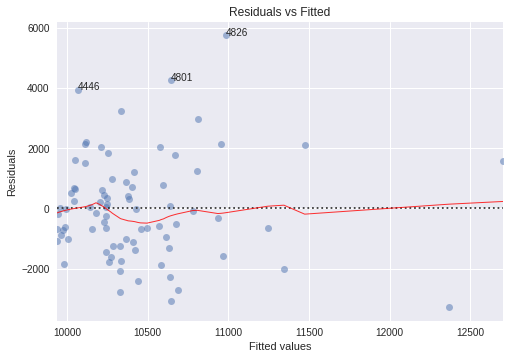

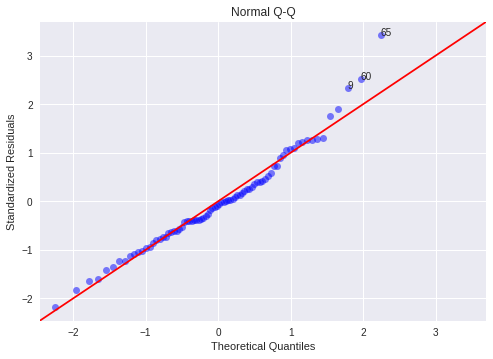

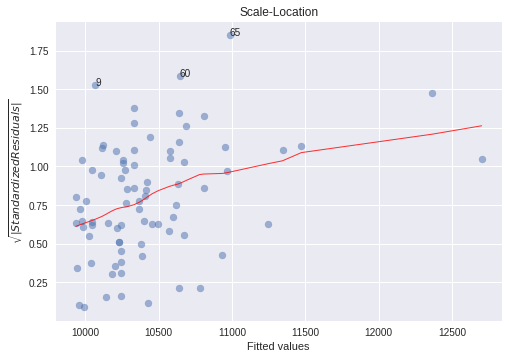

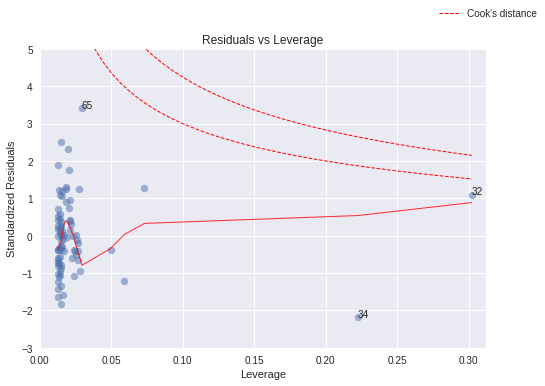

In [ ]:
diagnostic_plots(X,y)

In the above plot we can see that the data point 32 lies close to the border of Cook's distance, but it doesn't fall outside the dashed line. This means there are not any influental point in our regression model.
<br><br>

In the Appendix 6.2 we made the same analyses for the logarithmic version of the variables. Results are similar with a smaller effect of extreme values.

In [21]:
model_norm_residuals = model.get_influence().resid_studentized_internal
model_norm_residuals
# Residual ist the biggest for the municipality with the highest energa consumption (Mammern): tax_energy_2017.iloc[-15]

array([-0.41926268, -1.22661887,  0.24815068,  0.38874074, -1.11584045,
       -0.04677195, -0.56323833, -0.37218448, -0.60611761,  2.32893844,
       -0.93950267, -0.40515462,  0.01134417, -0.52890824,  0.20628368,
        1.30277449, -0.11655366,  0.14037351, -0.18309675,  0.17693735,
       -0.09345365, -0.01412031, -0.74196287, -1.63843786, -0.39427124,
       -1.59909481,  0.36371093, -1.04862303,  0.73596732, -1.22387318,
       -0.14642248,  0.45496456,  1.10143367, -0.30701244, -2.18012545,
       -0.39553835,  1.2620816 ,  0.41507632,  0.58101744, -1.02211587,
        0.30086867, -0.73153655,  1.7613241 , -1.34409266,  1.89822502,
        0.02547566, -1.42109101, -0.38370895, -0.39283488, -0.80511163,
        1.20667242, -0.78280911, -0.85222204, -1.0865482 ,  0.89749336,
       -0.40159658, -0.00798569, -0.65526499, -1.82023259,  0.04491097,
        2.51160465,  0.26402175,  1.21200084,  0.72171991,  1.0524187 ,
        3.41609823, -0.95788606, -0.26451269,  0.95318508,  1.28

In [22]:
tax_energy_2017.iloc[34]

Regionsname                    Bottighofen
Einkommen Total 2014              107.4557
Einkommen pro Person 2014    106076.702863
Einkommen Total 2015              120.6284
Einkommen pro Person 2015    113372.556391
Einkommen Total 2016              116.0548
Einkommen pro Person 2016    108563.891487
Einkommen Total 2017              126.1223
Einkommen pro Person 2017    117432.309125
Einkommen Total 2018              123.4656
Einkommen pro Person 2018    115388.411215
JAHR                                  2017
GEMEINDE_NAME                  Bottighofen
EINWOHNER                             2164
energiebezugsflaeche                196355
erdoelbrennstoffe                    6.833
erdgas                               7.653
elektrizitaet                        1.495
holzenergie                          1.532
fernwaerme                           0.132
umweltwaerme                         1.817
solarwaerme                          0.202
andere                                 NaN
Endenergiev

#5. Conclusion

The analysis shows a linear dependence between taxable income and energy consumption with a positive coefficient. The desired degree of certainty is reached. However, there seems to be a high estimation instability as revealed by the large condition number. It means it is difficult to determine a stable and precise linear relation between both variables.  
The relationship between the energy reference area and the energy consumption is more straightforward and within the desired degree of certainty. (see section  6.1). This provides a hint for the kind of dependence between income and consumption, as larger flats with more rooms consume more energy.

The model diagnosis for our main model shows in the Residuals vs Fitted plot that the residuals are evenly distributed around the horizontal line, and no particular pattern is apparent, indicating no nonlinear relationship.
The Q-Q plot shows a left-sided distribution.
The Scale-Location plot indicates a relative homogeneity of variance with a tendency to a more significant variance at higher incomes (this could also be due to the smaller data set of higher incomes).
The residual vs leverage plot does not show any points of strong leverage.
We can therefore assume that the assumptions for a linear regression model are largely fulfilled.

The analysis with the logarithmic version of the variables (see section 6.2) shows a slight improvement in the linear model which indicates that the most extreme values for income and consumption should not be weighted too much when estimating the model (some of them also being located in the  fat tail of the residuals).

The R² value of 0.07 is very low. It shows that only 7% of the variation in energy consumption can be explained by income, which means that other factors influence energy consumption.

On the one hand, the detail of the data at the municipality level could be too imprecise, and a consideration per household could give a different picture. On the other hand, everyone has a basic need for energy, which may outweigh the share of energy consumption related to income.
More detailed information would be needed to answer these questions.

The comparison with the different years shows that no significant changes are to be expected (see sections 6.3 and 6.4).




#6. More thoughts about the dataset

###6.1 Consideration of the energy consumption and the energy reference area

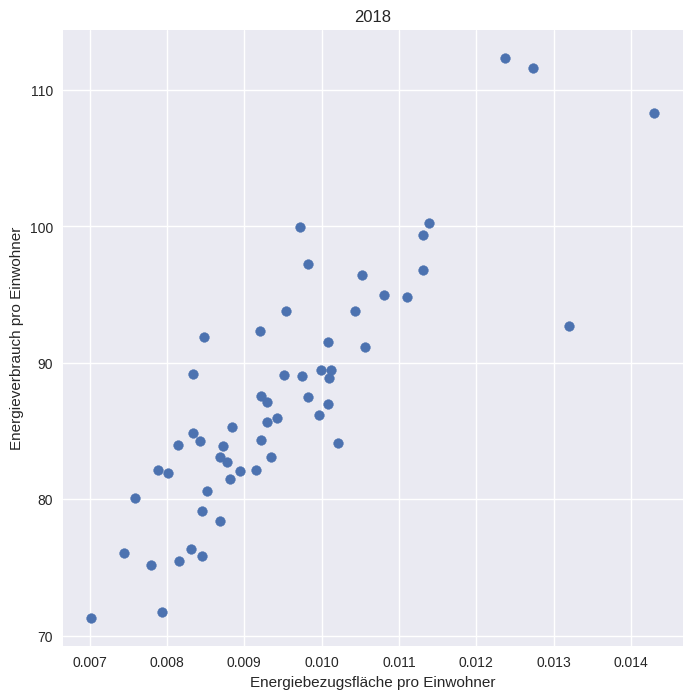

In [23]:
# Make our plots bigger.
plt.rcParams['figure.figsize'] = (8, 8)

fig, ax = plt.subplots()

# ax.scatter(tax_energy_2018["Einkommen pro Person 2018"], tax_energy_2018["total"]/tax_energy_2018["EINWOHNER"]/tax_energy_2018["energiebezugsflaeche"])
ax.scatter(tax_energy_2018["Endenergieverbrauch Total"]/tax_energy_2018["EINWOHNER"], tax_energy_2018["energiebezugsflaeche"]/tax_energy_2018["EINWOHNER"])

ax.set_title("2018")
plt.xlabel("Energiebezugsfläche pro Einwohner")
plt.ylabel("Energieverbrauch pro Einwohner")
# plt.legend()
plt.grid(visible=True)


# fig.savefig('test.png', dpi=300)

plt.show()

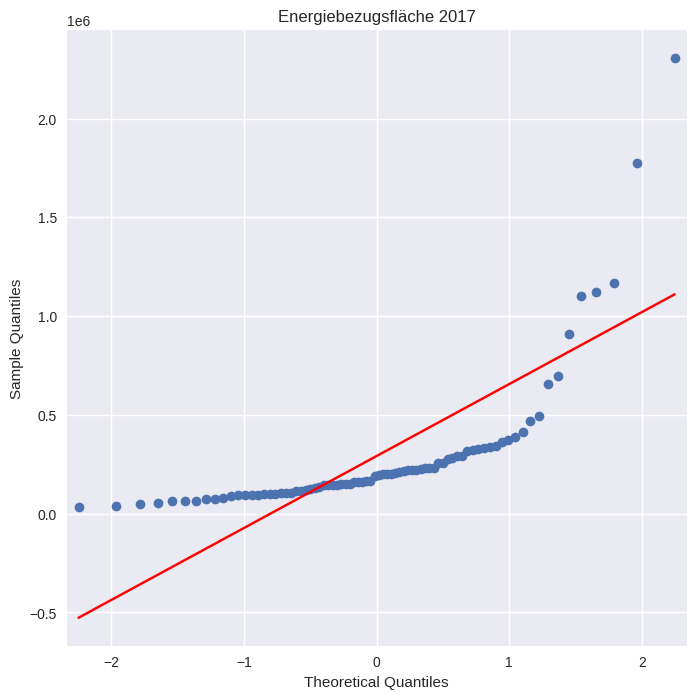



D'Agostino-Pearson normality test:
p = 0.000000
The data is not normaly distributed


In [24]:
a = tax_energy_2017["energiebezugsflaeche"]

fig = sm.qqplot(a, line="s")

# Make our plots bigger.
plt.rcParams['figure.figsize'] = (8, 8)

plt.title("Energiebezugsfläche 2017")
plt.show()

# D'Agostino-Pearson normality test
k2, p = stats.normaltest(a)
alpha = 1-0.05
print(f"\n\nD'Agostino-Pearson normality test:\np = {p:.6f}")
if p < alpha:
  print("The data is not normaly distributed")
else:
  print("The data is normaly distributed")

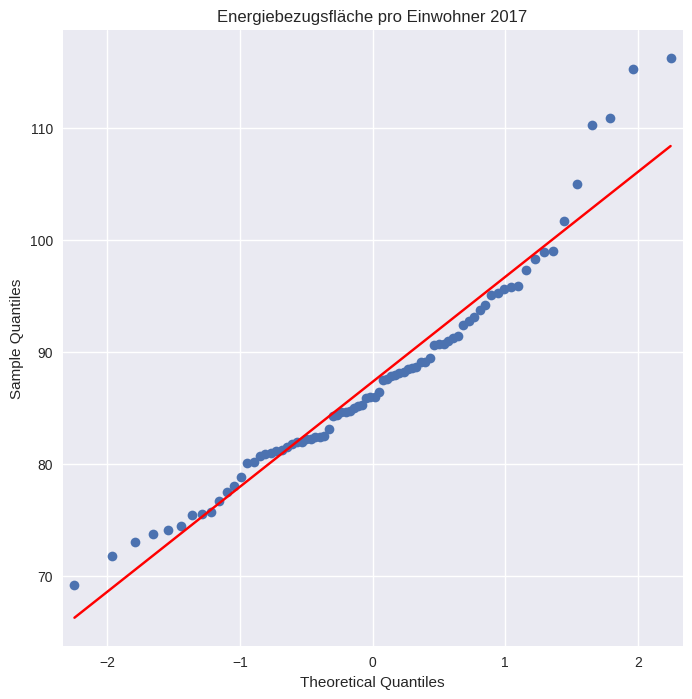



D'Agostino-Pearson normality test:
p = 0.001395
The data is not normaly distributed


In [25]:
a =  tax_energy_2017["energiebezugsflaeche"]/tax_energy_2017["EINWOHNER"]

fig = sm.qqplot(a, line="s")

# Make our plots bigger.
plt.rcParams['figure.figsize'] = (8, 8)

plt.title("Energiebezugsfläche pro Einwohner 2017")
plt.show()

# D'Agostino-Pearson normality test
k2, p = stats.normaltest(a)
alpha = 1-0.05
print(f"\n\nD'Agostino-Pearson normality test:\np = {p:.6f}")
if p < alpha:
  print("The data is not normaly distributed")
else:
  print("The data is normaly distributed")

In [26]:
# linear regression

X = tax_energy_2017["Endenergieverbrauch Total"]/tax_energy_2017["EINWOHNER"]
y = tax_energy_2017["energiebezugsflaeche"]/tax_energy_2017["EINWOHNER"]
X2 = sm.add_constant(X) # make sure that the model has an intercept
# est = sm.OLS(formula="volume ~ diam * height**2", endog=y, exog=x)
est = sm.OLS(y, X2) # run OLS
model = est.fit()

intercept, slope = model.params # print model parameters
std_intersept, std_slope = model.bse
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     169.9
Date:                Wed, 21 Sep 2022   Prob (F-statistic):           2.81e-21
Time:                        17:49:17   Log-Likelihood:                -246.31
No. Observations:                  80   AIC:                             496.6
Df Residuals:                      78   BIC:                             501.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.0553      3.602     11.399      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


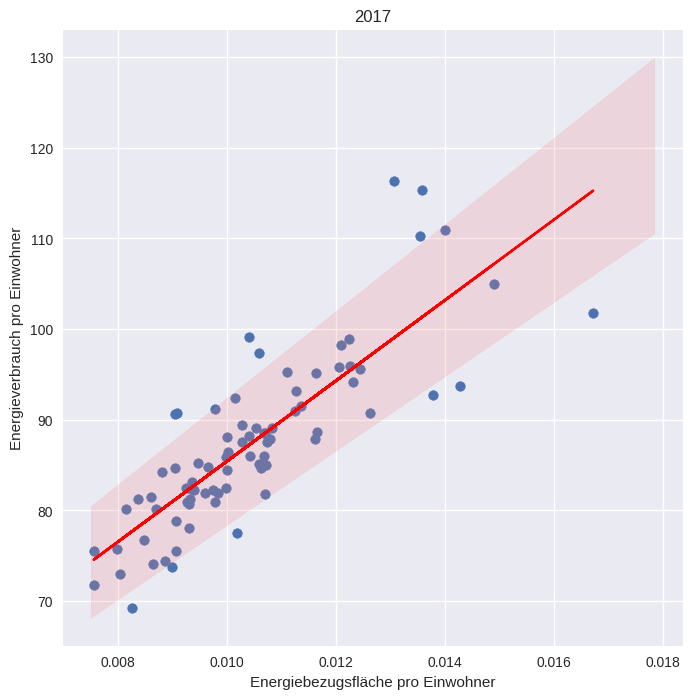

In [27]:
fig, ax = plt.subplots()

ax.scatter(tax_energy_2017["Endenergieverbrauch Total"]/tax_energy_2017["EINWOHNER"], tax_energy_2017["energiebezugsflaeche"]/tax_energy_2017["EINWOHNER"])
plt.plot(X, intercept + slope*X, 'r')
# plt.plot(X, (intercept + std_intersept) + (slope + std_slope) * X, 'g', label="SD")
# plt.plot(X, (intercept - std_intersept) + (slope - std_slope) * X, 'g')


X = np.linspace(0.0075, 0.01785, 10)
ax.fill_between(X, (intercept + std_intersept) + (slope + std_slope) * X, (intercept - std_intersept) + (slope - std_slope) * X, alpha=0.2, color="lightcoral")

ax.set_title("2017")
plt.xlabel("Energiebezugsfläche pro Einwohner")
plt.ylabel("Energieverbrauch pro Einwohner")
plt.legend()
plt.grid(visible=True)

# Make our plots bigger.
plt.rcParams['figure.figsize'] = (8, 8)

# fig.savefig('test.png', dpi=300)

plt.show()

Test: H0 Energy consumption per person is independent of the energy reference area

In [28]:
stats.mannwhitneyu(X, y, alternative='two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=2.9112061492231896e-07)

H0 can be rejected > energy consumption depends on the energy reference area > is not a surprise

To save energy, reduce the energy reference area, smaller apartments, do not heat all rooms.



###6.2 Reducing the effect of the the municipalities with the highest income pro person: logarithmic version of the variables

To verify how much the results depend on the few municipalities with the highest income and/or consumption pro person we repeat part of the results with the logarithmic version of the variables. This would also take into consideration the hypothesis that the Energy consumption should not increase so much any more with the highest income pro person. This means we would expect that the relationship between income and ernergy consumption should be clearer after logarithmic transformation, this mean by weighting less the extreme values. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


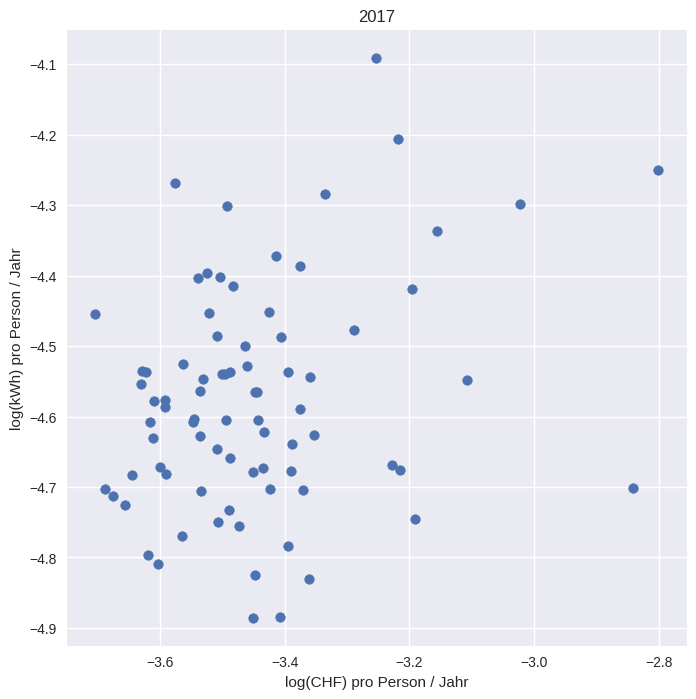

In [29]:
plt.rcParams['figure.figsize'] = (8, 8)

fig, ax = plt.subplots()

x = np.log(tax_energy_2017["Einkommen Total 2017"]/tax_energy_2017['EINWOHNER'])
y = np.log(tax_energy_2017['Endenergieverbrauch Total']/tax_energy_2017['EINWOHNER'])
           
ax.scatter(x,y)

ax.set_title("2017")
plt.xlabel("log(CHF) pro Person / Jahr")
plt.ylabel("log(kWh) pro Person / Jahr")
plt.legend()
plt.grid(visible=True)

# fig.savefig('test.png', dpi=300)

plt.show()


As the scatterplot of both income and consumption broadly looked like lognormal distributions, we test for both variables if the logarithm follows a normal distribution. It confirms for the energy consumption, but not for the taxable income.

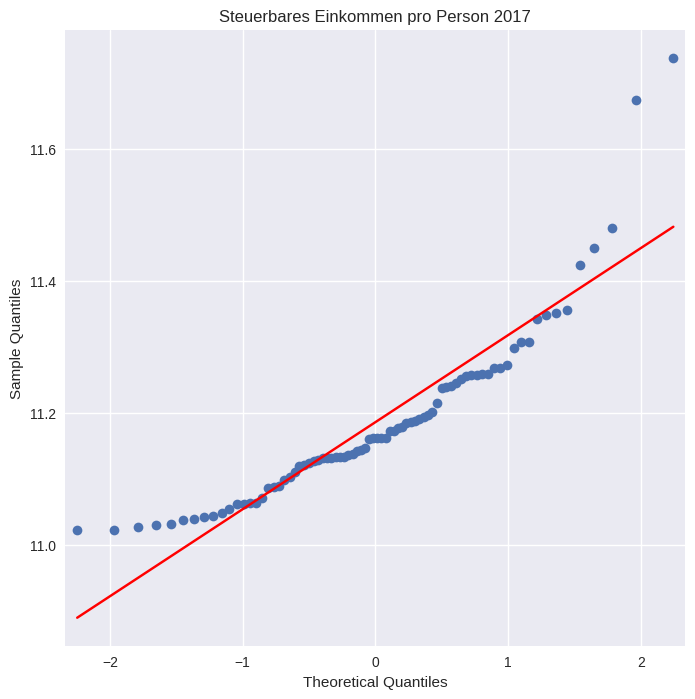



D'Agostino-Pearson normality test:
p = 0.000000
The data is not normaly distributed


In [30]:
a = np.log(tax_energy_2017["Einkommen pro Person 2017"])
#a = np.log(tax_energy_2017["Einkommen Total 2017"])/tax_energy_2017['STEUERPFLICHTIGE']
#a = np.log(tax_energy_2017["Einkommen Total 2017"])/tax_energy_2017['EINWOHNER']

# With no variant there is a lognormal distribution


fig = sm.qqplot(a, line="s")


# Make our plots bigger.
plt.rcParams['figure.figsize'] = (8, 8)

plt.title("Steuerbares Einkommen pro Person 2017")
plt.show()

# D'Agostino-Pearson normality test
k2, p = stats.normaltest(a)
alpha = 1-0.05
print(f"\n\nD'Agostino-Pearson normality test:\np = {p:.6f}")
if p < alpha:
  print("The data is not normaly distributed")
else:
  print("The data is normaly distributed")
  

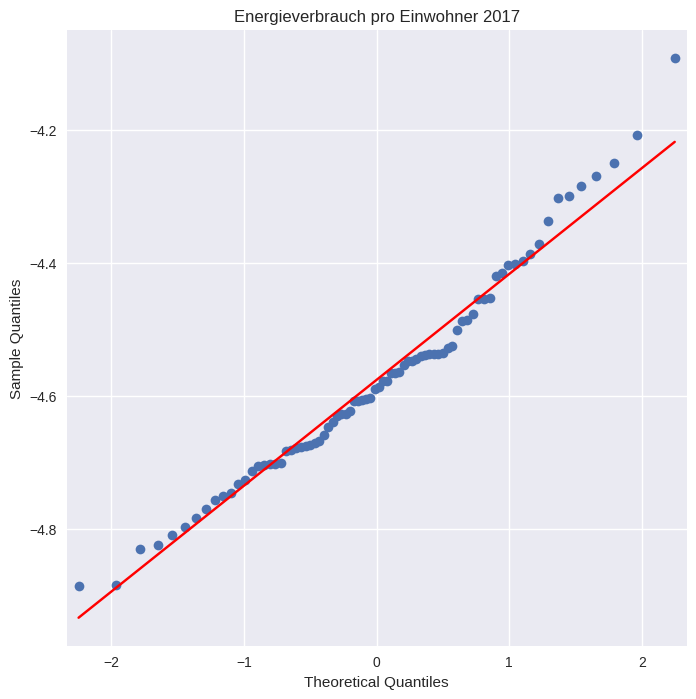



D'Agostino-Pearson normality test:
p = 0.091769
The data is not normaly distributed


In [31]:
a = np.log(tax_energy_2017['Endenergieverbrauch Total']/tax_energy_2017['EINWOHNER'])

fig = sm.qqplot(a, line="s")

# Make our plots bigger.
plt.rcParams['figure.figsize'] = (8, 8)

plt.title("Energieverbrauch pro Einwohner 2017")
plt.show()

# D'Agostino-Pearson normality test
k2, p = stats.normaltest(a)
alpha = 1-0.05  # is this the right alpha value? or should it be 0.95?
print(f"\n\nD'Agostino-Pearson normality test:\np = {p:.6f}")
if p < alpha:
  print("The data is not normaly distributed")
else:
  print("The data is normaly distributed")
  
 # tax_merged2['Log Eink pro Pers 2018'] =np.log(tax_merged2['Total 2018']/tax_merged2['EINWOHNER'])
#tax_merged2['Log Tot Energ pro Pers 2018'] =np.log(tax_merged2['total']/tax_merged2['EINWOHNER'])

In [32]:
# linear regression (auf den Log Varianten der Kennzahlen)

X = np.log(tax_energy_2017["Einkommen Total 2017"]/tax_energy_2017['EINWOHNER'])
y = np.log(tax_energy_2017['Endenergieverbrauch Total']/tax_energy_2017['EINWOHNER'])

X2 = sm.add_constant(X) # make sure that the model has an intercept
# est = sm.OLS(formula="volume ~ diam * height**2", endog=y, exog=x)
est = sm.OLS(y, X2) # run OLS
model = est.fit()

intercept, slope = model.params # print model parameters
std_intersept, std_slope = model.bse
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     6.548
Date:                Wed, 21 Sep 2022   Prob (F-statistic):             0.0124
Time:                        17:49:36   Log-Likelihood:                 36.577
No. Observations:                  80   AIC:                            -69.15
Df Residuals:                      78   BIC:                            -64.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6731      0.353    -10.403      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


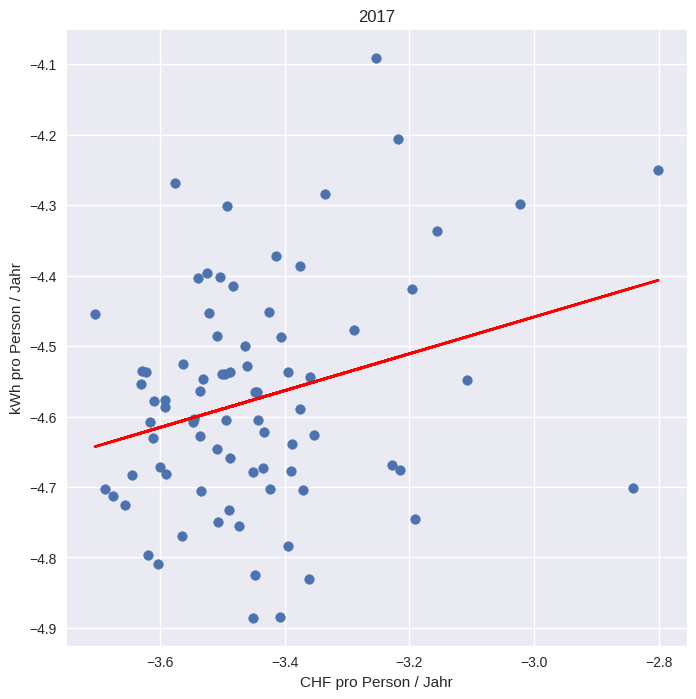

In [33]:
fig, ax = plt.subplots()

ax.scatter(np.log(tax_energy_2017["Einkommen Total 2017"]/tax_energy_2017['EINWOHNER']), np.log(tax_energy_2017['Endenergieverbrauch Total']/tax_energy_2017['EINWOHNER']))
plt.plot(X, intercept + slope*X, 'r')
# plt.plot(X, (intercept + std_intersept) + (slope + std_slope) * X, 'g', label="SD")
# plt.plot(X, (intercept - std_intersept) + (slope - std_slope) * X, 'g')


#X2 = np.linspace(-3, -2, 1)
#ax.fill_between(X2, (intercept + std_intersept) + (slope + std_slope) * X2, (intercept - std_intersept) + (slope - std_slope) * X2, alpha=0.2)

ax.set_title("2017")
plt.xlabel("CHF pro Person / Jahr")
plt.ylabel("kWh pro Person / Jahr")
plt.legend()
plt.grid(visible=True)

# Make our plots bigger.
plt.rcParams['figure.figsize'] = (8, 8)

# fig.savefig('test.png', dpi=300)

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. F

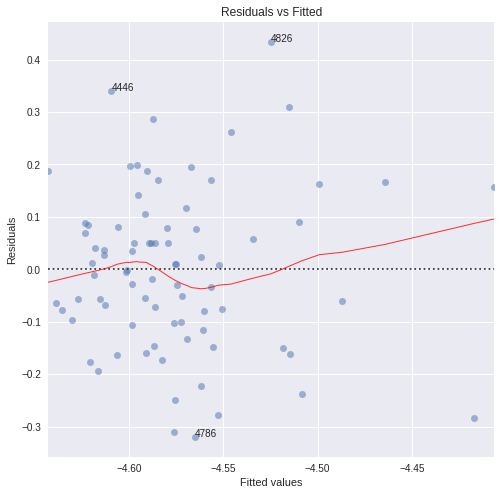

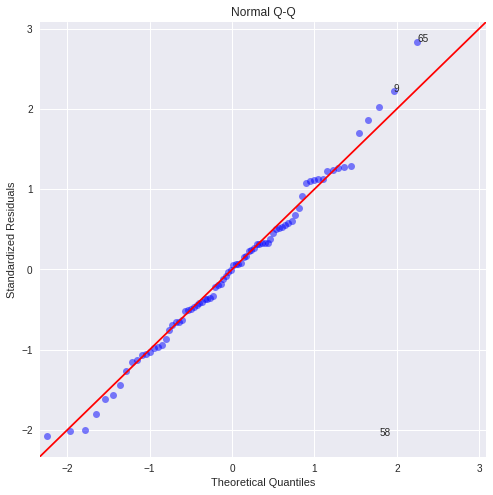

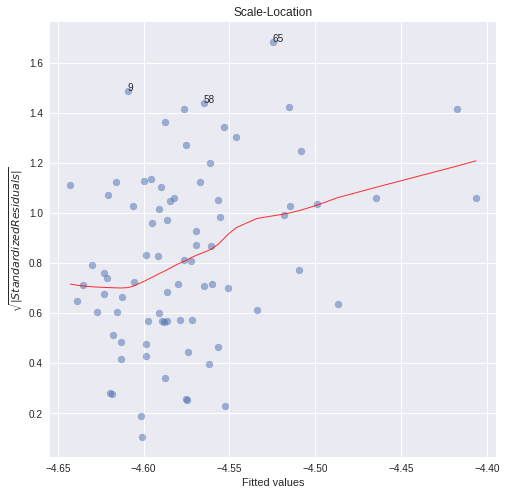

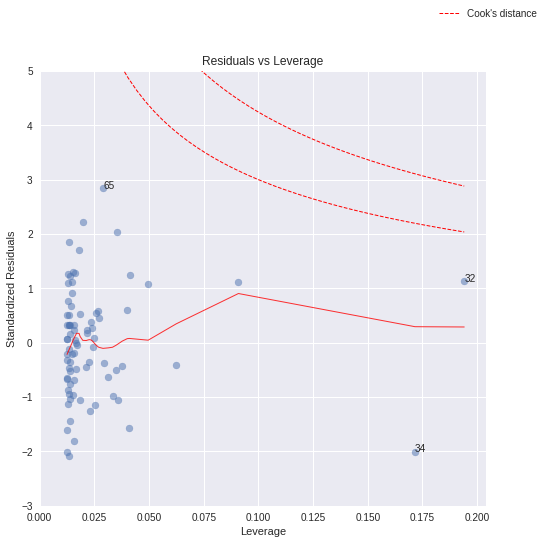

In [ ]:
diagnostic_plots(X,y)

###6.3 Income Data not available for all Regions in 2018

In [34]:
# This has an impact on the regression results 
# On the subset, the linear relationship between Income and Energy consumption does not hold any more

X = tax_energy_2018["Einkommen pro Person 2018"].astype ( float )
y = tax_energy_2018["Endenergieverbrauch Total"]/tax_energy_2018["EINWOHNER"] *1000*1000

X2 = sm.add_constant(X) # make sure that the model has an intercept
# est = sm.OLS(formula="volume ~ diam * height**2", endog=y, exog=x)
est = sm.OLS(y, X2) # run OLS
model = est.fit()

intercept, slope = model.params # print model parameters
std_intersept, std_slope = model.bse
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.809
Date:                Wed, 21 Sep 2022   Prob (F-statistic):              0.184
Time:                        17:49:43   Log-Likelihood:                -494.17
No. Observations:                  57   AIC:                             992.3
Df Residuals:                      55   BIC:                             996.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [35]:
# let us check if this is mainly due to the missing Regions or to very different Energy Data in 2018
# For the missing regions only , we replace the missing Income of 2018 with the old values of 2017
tax_energy_2018_compl = pd.concat([tax_df, df_ener_2018], axis=1)
tax_energy_2018_compl['Einkommen pro Person 2018 od. 2017'] = np.where(tax_energy_2018_compl['Einkommen pro Person 2018']==  'X', tax_energy_2018_compl[ 'Einkommen pro Person 2017'], tax_energy_2018_compl[ 'Einkommen pro Person 2018']) 
tax_energy_2018_compl['Missing_2018'] = np.where(tax_energy_2018_compl['Einkommen pro Person 2018']==  'X', 'r','b') 


In [36]:
tax_energy_2018_compl[['Einkommen pro Person 2018','Einkommen pro Person 2017','Einkommen pro Person 2018 od. 2017', 'Missing_2018']]

,Einkommen pro Person 2018,Einkommen pro Person 2017,Einkommen pro Person 2018 od. 2017,Missing_2018
Regions-ID,,,,
4401,62046.13724,62181.738723,62046.13724,b
4406,71612.962963,70391.044776,71612.962963,b
4411,72537.590014,71482.347236,72537.590014,b
4416,X,63819.718310,63819.71831,r
4421,79149.232822,76156.901218,79149.232822,b
...,...,...,...,...
4911,61042.189422,61250.878294,61042.189422,b
4921,64447.502548,63728.423237,64447.502548,b
4941,74761.241484,71200.865460,74761.241484,b


In [37]:
# This has an impact on the regression result. 
# On the subset, the relationship between Income and Energy consumption does not hold any more
# linear regression

X = tax_energy_2018_compl["Einkommen pro Person 2018 od. 2017"].astype ( float )
y = tax_energy_2018_compl["Endenergieverbrauch Total"]/tax_energy_2018_compl["EINWOHNER"] *1000*1000

X2 = sm.add_constant(X) # make sure that the model has an intercept
# est = sm.OLS(formula="volume ~ diam * height**2", endog=y, exog=x)
est = sm.OLS(y, X2) # run OLS
model = est.fit()

intercept, slope = model.params # print model parameters
std_intersept, std_slope = model.bse
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     6.733
Date:                Wed, 21 Sep 2022   Prob (F-statistic):             0.0113
Time:                        17:49:52   Log-Likelihood:                -705.53
No. Observations:                  80   AIC:                             1415.
Df Residuals:                      78   BIC:                             1420.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


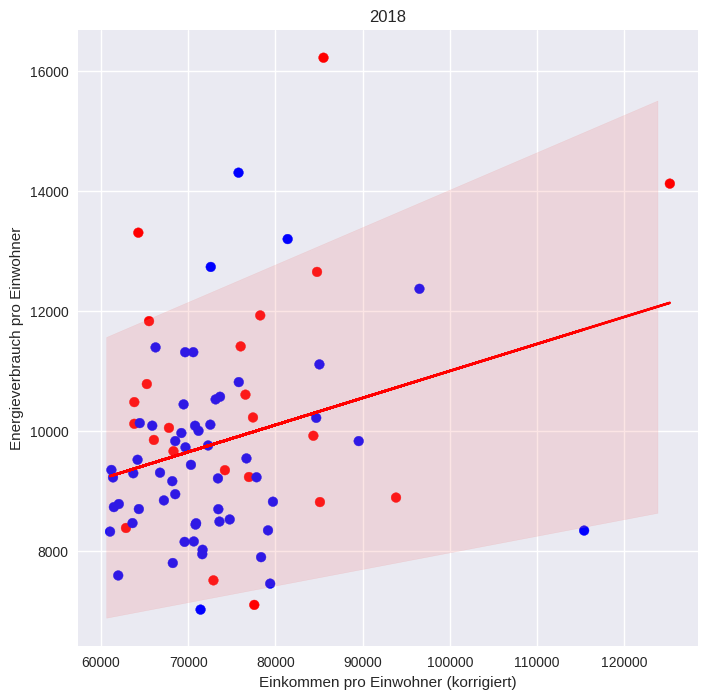

In [38]:
fig, ax = plt.subplots()

ax.scatter(tax_energy_2018_compl["Einkommen pro Person 2018 od. 2017"], tax_energy_2018_compl["Endenergieverbrauch Total"]/tax_energy_2018_compl["EINWOHNER"]*1000*1000, c=tax_energy_2018_compl['Missing_2018'])
plt.plot(X, intercept + slope*X, 'r')
# plt.plot(X, (intercept + std_intersept) + (slope + std_slope) * X, 'g', label="SD")
# plt.plot(X, (intercept - std_intersept) + (slope - std_slope) * X, 'g')


X = np.linspace(60600, 123800, 10)
ax.fill_between(X, (intercept + std_intersept) + (slope + std_slope) * X, (intercept - std_intersept) + (slope - std_slope) * X, color="lightcoral" , alpha=0.2 )

ax.set_title("2018")
plt.xlabel("Einkommen pro Einwohner (korrigiert)")
plt.ylabel("Energieverbrauch pro Einwohner")
plt.legend()
plt.grid(visible=True)

# Make our plots bigger.
plt.rcParams['figure.figsize'] = (8, 8)

# fig.savefig('test.png', dpi=300)

plt.show()

###6.4 Regression results for the years 2015 and 2016 are similar

We focussed above on year 2017 for the analysis of the relationship between taxable income and energy consumption. Here we present the result of the regression for 2015 and 2016. We noticed that the distributions of the two variables are similar over time. But if we apply a Wilcoxon signed-rank test to check if the paired, not normal distributions are really the same (we have shown above that they are not normally distributed), we can reject the hypothesis that they are with a very high confidence level for both variables and for both years 2015 and 2016. This is an indication that the results of the regression for these two years may not automatically be the same. Results for 2018 are shown in chapter 6.3.

Comparison of the Income distribution for the 3 years:

In [39]:
stats.wilcoxon(tax_energy_2017["Einkommen pro Person 2017"],tax_energy_2017["Einkommen pro Person 2016"], alternative='two-sided')

WilcoxonResult(statistic=534.0, pvalue=1.9009873797293655e-07)

In [40]:
stats.wilcoxon(tax_energy_2017["Einkommen pro Person 2017"],tax_energy_2017["Einkommen pro Person 2015"], alternative='two-sided')

WilcoxonResult(statistic=292.0, pvalue=1.896832687283602e-10)

In [41]:
stats.wilcoxon(tax_energy_2017["Einkommen pro Person 2016"],tax_energy_2017["Einkommen pro Person 2015"], alternative='two-sided')

WilcoxonResult(statistic=466.0, pvalue=3.113785779809716e-08)

Comparison of the Consumption distribution for the 3 years:

In [42]:
stats.wilcoxon(tax_energy_2017['Endenergieverbrauch Total']/tax_energy_2017['EINWOHNER'],tax_energy_2016['Endenergieverbrauch Total']/tax_energy_2016['EINWOHNER'],alternative='two-sided')

WilcoxonResult(statistic=1002.0, pvalue=0.0030356420877229156)

In [43]:
stats.wilcoxon(tax_energy_2017['Endenergieverbrauch Total']/tax_energy_2017['EINWOHNER'],tax_energy_2015['Endenergieverbrauch Total']/tax_energy_2015['EINWOHNER'],alternative='two-sided')

WilcoxonResult(statistic=263.0, pvalue=7.587373529714144e-11)

In [44]:
stats.wilcoxon(tax_energy_2016['Endenergieverbrauch Total']/tax_energy_2016['EINWOHNER'],tax_energy_2015['Endenergieverbrauch Total']/tax_energy_2015['EINWOHNER'],alternative='two-sided')

WilcoxonResult(statistic=158.0, pvalue=2.3464669195643163e-12)

Regression results for the years 2016 and 2015. <br> The relationship between both variables holds here too. <br> This is a confirmation that results are relatively stable as they hold over all the years included the completed year 2018 (see chapter 6.3). But we have to mention that the test samples here are not independant, as they are paired valued of the same municipalities.

In [45]:
# linear regression

X = tax_energy_2016["Einkommen pro Person 2016"]
y = tax_energy_2016["Endenergieverbrauch Total"]/tax_energy_2016["EINWOHNER"]*1000*1000

X2 = sm.add_constant(X) # make sure that the model has an intercept
# est = sm.OLS(formula="volume ~ diam * height**2", endog=y, exog=x)
est = sm.OLS(y, X2) # run OLS
model = est.fit()

intercept, slope = model.params # print model parameters
std_intersept, std_slope = model.bse
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     6.378
Date:                Wed, 21 Sep 2022   Prob (F-statistic):             0.0136
Time:                        17:50:06   Log-Likelihood:                -709.58
No. Observations:                  80   AIC:                             1423.
Df Residuals:                      78   BIC:                             1428.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [46]:
# linear regression

X = tax_energy_2015["Einkommen pro Person 2015"]
y = tax_energy_2015["Endenergieverbrauch Total"]/tax_energy_2015["EINWOHNER"]*1000*1000

X2 = sm.add_constant(X) # make sure that the model has an intercept
# est = sm.OLS(formula="volume ~ diam * height**2", endog=y, exog=x)
est = sm.OLS(y, X2) # run OLS
model = est.fit()

intercept, slope = model.params # print model parameters
std_intersept, std_slope = model.bse
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     5.613
Date:                Wed, 21 Sep 2022   Prob (F-statistic):             0.0203
Time:                        17:50:06   Log-Likelihood:                -710.63
No. Observations:                  80   AIC:                             1425.
Df Residuals:                      78   BIC:                             1430.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 